In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import numpy as np

from pytorched.step_by_step import StepByStep

from torchviz import make_dot
plt.style.use('fivethirtyeight')

%load_ext autoreload
%autoreload 2

# Quadratic regression using sklear

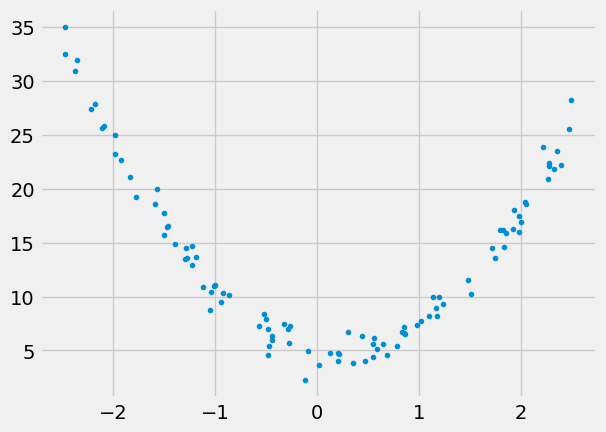

In [ ]:
np.random.seed(43)
a0, a1, a2 = 5., -1.5, +4.
N = 100
x = -2.5 + 5*np.random.rand(N,1)
epsilon = np.random.randn(N,1)
y = a0 + a1*x + a2*x**2 + epsilon
plt.plot(x,y,'.')
plt.show()

Somewhat counterintuitively but this problem is still [linear regression](https://scikit-learn.org/stable/modules/linear_model.html?highlight=polynomial+regression#polynomial-regression-extending-linear-models-with-basis-functions). We just need to first convert `x` to `new_x` that basically contains extra features: $x^0$, $x^1$, and $x^2$. This is done via `PolynomialFeatures`:

In [ ]:
poly = PolynomialFeatures(degree=2)
new_x = poly.fit_transform(x)  # for degree 2 we get $[1, x, x^2]$
new_x[:10]

array([[ 1.        , -1.92472717,  3.70457467],
       [ 1.        ,  0.5453327 ,  0.29738775],
       [ 1.        , -1.83304518,  3.36005463],
       [ 1.        , -1.2970519 ,  1.68234363],
       [ 1.        , -0.86430472,  0.74702265],
       [ 1.        ,  1.79568745,  3.22449344],
       [ 1.        ,  0.83045107,  0.68964897],
       [ 1.        ,  0.20581106,  0.04235819],
       [ 1.        , -2.35493088,  5.54569944],
       [ 1.        ,  1.16874148,  1.36595665]])

We now progress as with the linear regression (not that using `fit_intercept` True or False just affects the way numbers are stored, all calculations are still there):

In [ ]:
reg = LinearRegression(fit_intercept=False).fit(new_x, y)
r2_coef = reg.score(new_x, y)
print(reg.coef_, reg.intercept_, r2_coef)

[[ 4.98812164 -1.61954639  4.02342307]] 0.0 0.9831534879311261


## Using sklearn.pipeline

One can make the process more streamlined using `Pipeline`:

In [ ]:
model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))])
# fit to an order-2 polynomial data
model = model.fit(x, y)
model.named_steps['linear'].coef_

array([[ 4.98812164, -1.61954639,  4.02342307]])

# Using PyTorch

Let's first split data, create `Datasets`, and `DataLoaders`:

## Data Preparation 

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
np.random.seed(42)
N = len(x)
idx = list(range(N))
np.random.shuffle(idx)

In [ ]:
split_idx = int(.8*N)
train_idx = idx[:split_idx]
val_idx = idx[split_idx:]
train_x = torch.as_tensor(x[train_idx], device=device).float()
train_y = torch.as_tensor(y[train_idx], device=device).float()
val_x = torch.as_tensor(x[val_idx], device=device).float()
val_y = torch.as_tensor(y[val_idx], device=device).float()

In [ ]:
train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

## Training

In [ ]:
model=nn.Sequential(
        nn.Linear(1,5),
        nn.ReLU(),
        nn.Linear(5,1)
)
optimizer = optim.Adam(model.parameters(), lr=0.1)
loss_fn = nn.MSELoss()

sbs = StepByStep(model, optimizer, loss_fn)

Let's train for 200 epoch and plot losses:


In [ ]:
sbs.set_loaders(train_loader, val_loader)
sbs.train(200)

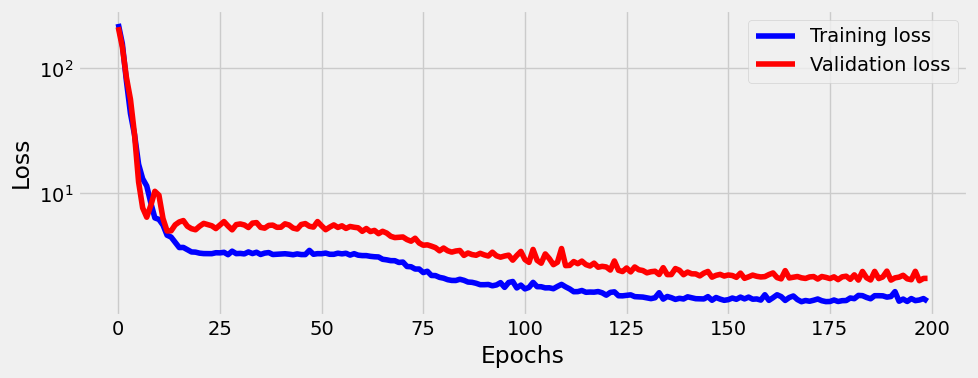

In [ ]:
sbs.plot_losses()

Let's make predictions:

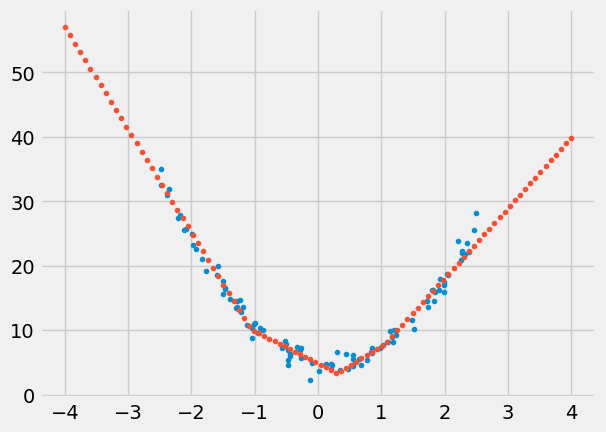

In [ ]:
test =np.linspace(-4.,4.,num=N).reshape(-1,1)
test_predictions = sbs.predict(test)
plt.plot(x,y,'.')
plt.plot(test,test_predictions,'.')
plt.show()

Unfortunatelly, the true values of quadratic function are now lost in the sea of weights of the the two linear layers:

In [ ]:
sbs.model.state_dict()

OrderedDict([('0.weight',
              tensor([[-3.3807],
                      [-2.5312],
                      [ 3.6842],
                      [ 0.2904],
                      [-0.0723]])),
             ('0.bias', tensor([-3.5956,  2.6352, -1.0997, -0.8423, -0.8262])),
             ('2.weight', tensor([[3.2337, 1.9828, 2.9446, 0.2435, 0.5650]])),
             ('2.bias', tensor([-0.3613]))])